The goal of this analysis is to create a linear classification model and a non-linear method that detects if a patient has a heart disease.

In [3]:
import warnings
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [4]:
from ucimlrepo import fetch_ucirepo 
heart_disease = fetch_ucirepo(id=45)  
X = heart_disease.data.features 
y = heart_disease.data.targets 

Data types check
The dataset consists of 14 variables and 303 units related to a heart disease in Cleveland. 

In [5]:
X.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
dtype: object

In [6]:
y.dtypes

num    int64
dtype: object

In [7]:
X.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64

When the dataset is uploaded, the notebook initially interprets all variables as numeric, which leads to incorrect
data types for some of them.

In [ ]:
for i in [1,2,5,6,8,10,12]:
  X[X.columns[i]]=X[X.columns[i]].astype("category")

In [8]:
y.isnull().sum()

num    0
dtype: int64

There are a few missing values in the dataset. Although these NaN values could be imputed (e.g., with the mean, median, etc.), given that there are only six missing entries, the imputation may not provide significant value. Currently, at the moment the data remains untransformed, as the columns containing missing values may not be related to the target variable. Dropping these rows now could result in the loss of potentially useful information.

In [10]:
X.dtypes

age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca           float64
thal        category
dtype: object

Initially, the data represents the severity of the disease on a scale from 1 to 4. As mentioned in the data repository, the goal is to detect the presence or absence of the disease, so the target variable needs to be converted into a binary format (1, 0).

In [11]:
import pandas as pd
for i in range(len(y["num"])):
  if y["num"][i] in [1,2,3,4]:
    y["num"][i]=1
  else:
    y["num"][i]=0

In [12]:
y["num"].value_counts()

num
0    164
1    139
Name: count, dtype: int64

Target Variable Study

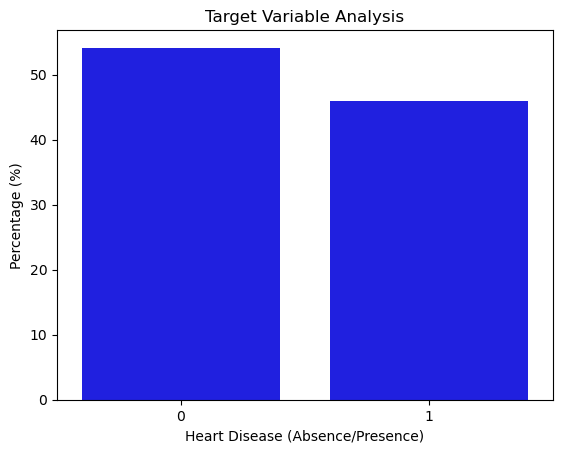

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

percentages = (y["num"].value_counts() * 100) / len(y)
sns.barplot(x=percentages.index, y=percentages.values, color="b")

plt.title("Target Variable Analysis")
plt.xlabel("Heart Disease (Absence/Presence)")
plt.ylabel("Percentage (%)")
plt.show()

In [14]:
round(((y["num"].value_counts() * 100) / len(y)),3)

num
0    54.125
1    45.875
Name: count, dtype: float64

When the target variable is encoded in binary format, the representation of the categories does not become unbalanced.

Categorical Variables Study

In [15]:
cat=X.select_dtypes(include="category")
cat.dtypes

sex        category
cp         category
fbs        category
restecg    category
exang      category
slope      category
thal       category
dtype: object

In [16]:
round((y[y["num"] == 1].value_counts()*100)/len(y),3)

num
1      45.875
Name: count, dtype: float64

This represents the percentage of patients who have contracted this heart disease and serves as a reference to determine whether the categories of the categorical variables align with the overall percentage

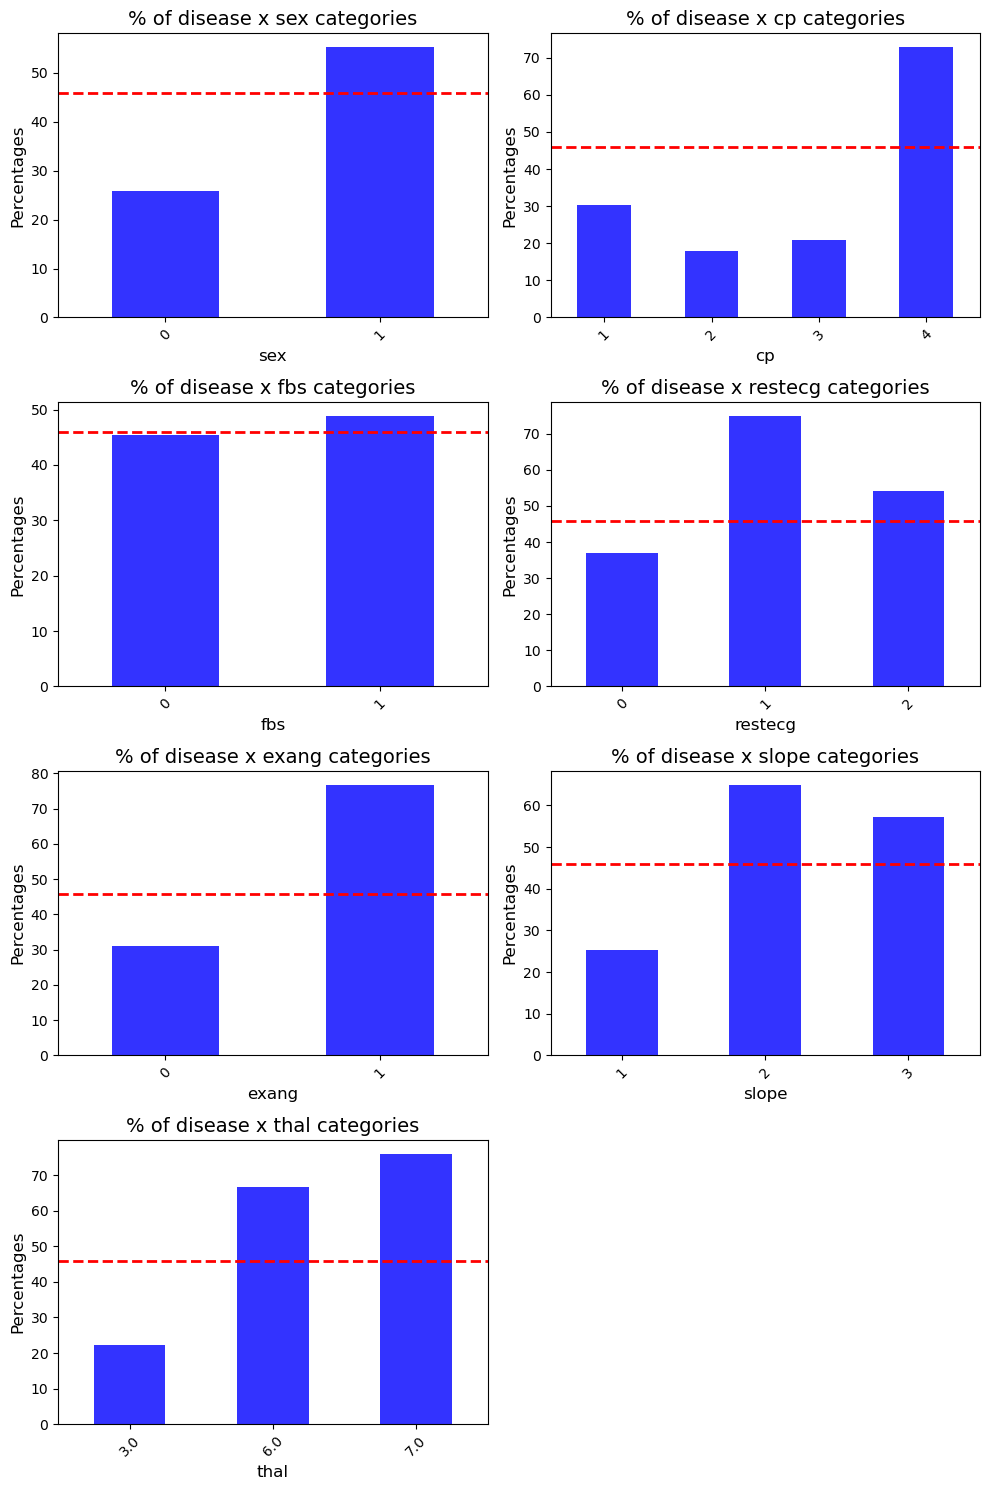

In [17]:
import matplotlib.pyplot as plt
import numpy as np

colplot = cat.columns

fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()

for i, column in enumerate(colplot):
    ax = axes[i]
    
    ((y[y["num"] == 1].groupby(cat[column]).size() * 100) / (cat.groupby(cat[column]).size())).plot(kind="bar",color="b", alpha=0.8, ax=ax)
    ax.axhline(y=45.875, color="r", linestyle="--", linewidth=2, label="Threshold 45.875")

    
    ax.set_title(f"% of disease x {column} categories", fontsize=14)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel("Percentages", fontsize=12)
    ax.tick_params(axis="x", rotation=45)

 
for j in range(i + 1, len(axes)):
    axes[j].axis('off')  

plt.tight_layout()
plt.show()

Based on the bar analysis, all variables appear to be explanatory of the target, except for 'fbs'. To confirm this, a Chi-Square test will be performed.

In [19]:
import pandas as pd
from scipy.stats import chi2_contingency

y["num"] = y["num"].astype("category")

p_values = []

for column in cat.columns:
    contingency_table = pd.crosstab(cat[column], y["num"])
    chi2, p, dof, expected= chi2_contingency(contingency_table)
    p_values.append(p)

p_values_df = pd.DataFrame(p_values, index=cat.columns, columns=["p-value"])
print(p_values_df)

              p-value
sex      2.666712e-06
cp       1.251711e-17
fbs      7.812734e-01
restecg  6.566524e-03
exang    1.413788e-13
slope    1.142885e-10
thal     8.201820e-19


In [20]:
cat=cat.drop("fbs",axis=1)

Chi-Square confirms what was seen in the previous charts. "fbs" has a p-value>0.05, this means there isn't a significant relation with the target variable.

Numeric Variables Analysis

In [21]:
num=X.select_dtypes("number")
num.dtypes

age           int64
trestbps      int64
chol          int64
thalach       int64
oldpeak     float64
ca          float64
dtype: object

In [22]:
num["num"] = y["num"].astype("int64") 
corr=num.corr()
corr.style.background_gradient(cmap="coolwarm")

,age,trestbps,chol,thalach,oldpeak,ca,num
age,1.000000,0.284946,0.208950,-0.393806,0.203805,0.362605,0.223120
trestbps,0.284946,1.000000,0.130120,-0.045351,0.189171,0.098773,0.150825
chol,0.208950,0.130120,1.000000,-0.003432,0.046564,0.119000,0.085164
thalach,-0.393806,-0.045351,-0.003432,1.000000,-0.343085,-0.264246,-0.417167
oldpeak,0.203805,0.189171,0.046564,-0.343085,1.000000,0.295832,0.424510
ca,0.362605,0.098773,0.119000,-0.264246,0.295832,1.000000,0.460442
num,0.223120,0.150825,0.085164,-0.417167,0.424510,0.460442,1.000000


Before making any decisions based solely on correlation, it's advisable to seek a second opinion. For this reason, the variables can be grouped into bins and compared to the target variable, as was done previously with the categorical variables

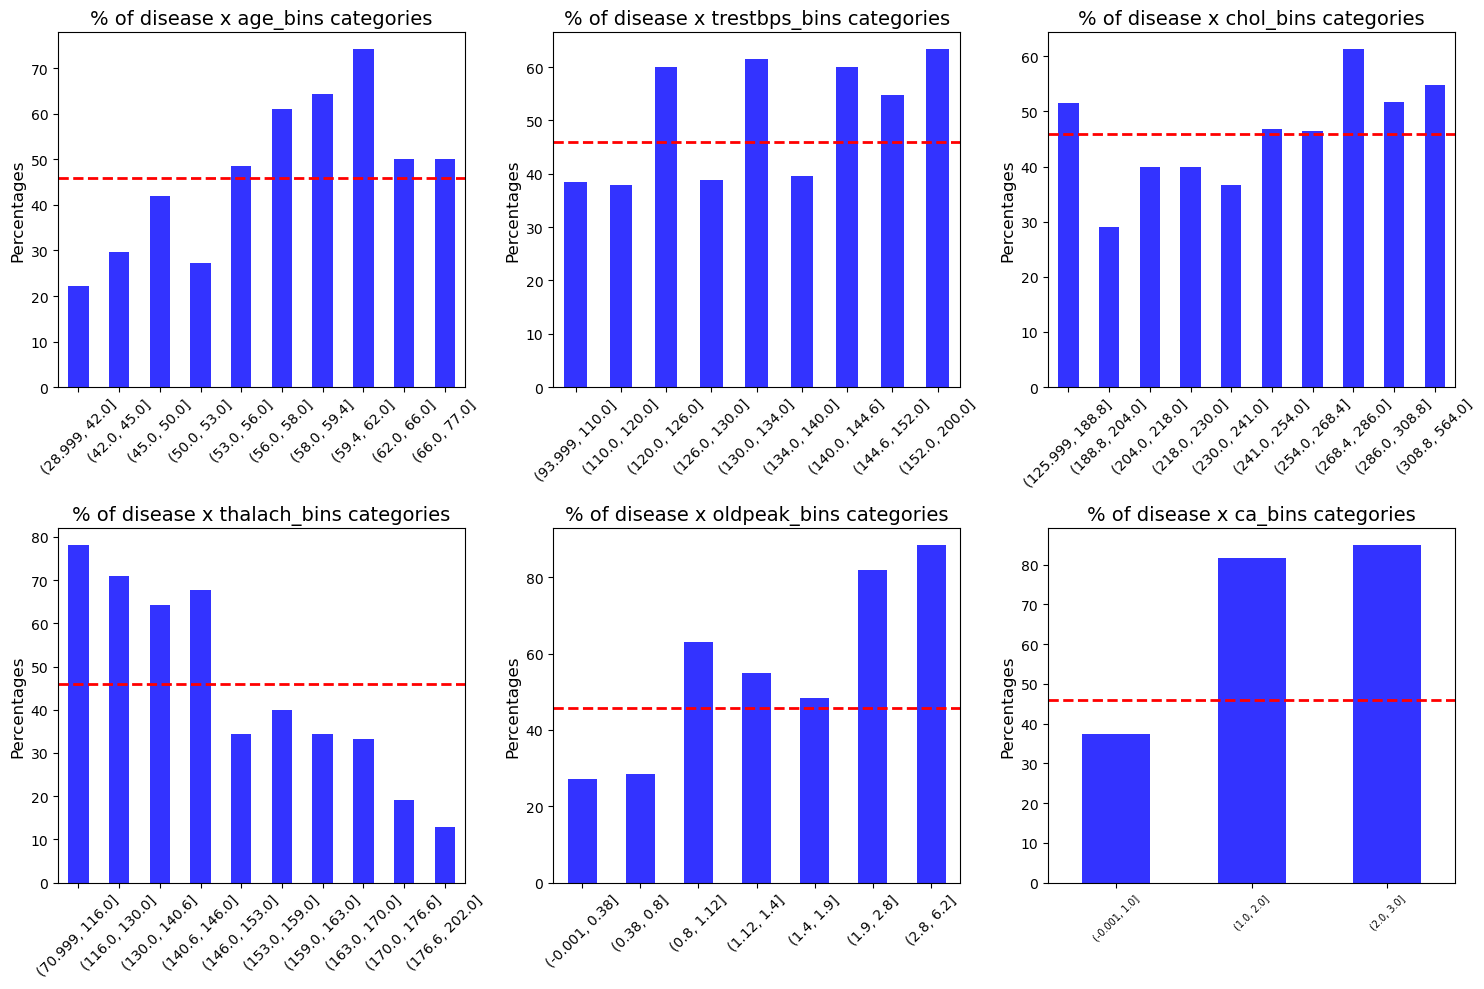

In [23]:
numbin=num.copy()
numbin=numbin.drop("num",axis=1)
colbin= numbin.columns

fig,axes=plt.subplots(2,3,figsize=(15,10))
axes=axes.flatten()

for i, column in enumerate(colbin):
    ax = axes[i]
    numbin[f"{column}_bins"]=pd.qcut(numbin[column],q=10,duplicates="drop")

    ((y[y["num"] == 1].groupby(numbin[f"{column}_bins"]).size() * 100) / (numbin.groupby(numbin[f"{column}_bins"]).size())).plot(kind="bar",color="b", alpha=0.8, ax=ax)
    ax.axhline(y=45.875, color="r", linestyle="--", linewidth=2, label="Threshold 45.875")

    
    ax.set_title(f"% of disease x {column}_bins categories", fontsize=14)
    ax.set_xlabel(None)
    ax.set_ylabel("Percentages", fontsize=12)
    plt.xticks(fontsize=7)
    ax.tick_params(axis="x", rotation=45)
    
plt.subplots_adjust(hspace=0.4, wspace=0.4)  
plt.tight_layout()

plt.show()


Q-cut divides a continuous variable into quantile-based bins, ensuring that each bin has approximately equal frequency. The variables 'trestbps' and 'chol' both show a low correlation with the target. When binned and analyzed against the percentage of heart disease occurrence, they do not reveal a clear pattern. For these reasons, they can be excluded from further analysis.

In [24]:
num=num.drop(["trestbps","chol"],axis=1)
corr = num.corr()
masked_corr =corr.where((corr < -0.8) | (corr > 0.8))
masked_corr.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}")

,age,thalach,oldpeak,ca,num
age,1.00,nan,nan,nan,nan
thalach,nan,1.00,nan,nan,nan
oldpeak,nan,nan,1.00,nan,nan
ca,nan,nan,nan,1.00,nan
num,nan,nan,nan,nan,1.00


There is no clear evidence of multicollinearity

Linear Classification Model
Logistic Regression cannot process categorical variables directly, so encoding is necessary.  

- The variables 'sex' and 'exang' do not require encoding as they are already binary.  
- The variables 'cp', 'thalach', and 'restecg' are ordinal and can be encoded using Label Encoding.  
- The variable 'slope', being categorical, should be encoded using One-Hot Encoding.  

This ensures that the data is properly prepared for the Logistic Regression model.

In [25]:
fin = pd.concat([num, cat], axis=1)
fin.isnull().sum()

age        0
thalach    0
oldpeak    0
ca         4
num        0
sex        0
cp         0
restecg    0
exang      0
slope      0
thal       2
dtype: int64

The missing values persist even after computing the variable selection. Hence we ddrop those values.

In [26]:
fin=fin.dropna()
fin1=fin.copy()

In [27]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()

fin1["cp"]=le.fit_transform(fin1["cp"])
fin1["thal"]=le.fit_transform(fin1["thal"])
fin1["restecg"]=le.fit_transform(fin1["restecg"])

fin1=pd.get_dummies(fin1,columns=["slope"],drop_first=True)

In [28]:
fin1["num"]=fin1["num"].astype("category")
fin1.dtypes

age           int64
thalach       int64
oldpeak     float64
ca          float64
num        category
sex        category
cp            int64
restecg       int64
exang      category
thal          int64
slope_2        bool
slope_3        bool
dtype: object

Train-Test

In [29]:
X=fin1.drop("num",axis=1)
y=fin1["num"]

In [30]:
X.head

<bound method NDFrame.head of      age  thalach  oldpeak   ca sex  cp  restecg exang  thal  slope_2  slope_3
0     63      150      2.3  0.0   1   0        2     0     1    False     True
1     67      108      1.5  3.0   1   3        2     1     0     True    False
2     67      129      2.6  2.0   1   3        2     1     2     True    False
3     37      187      3.5  0.0   1   2        0     0     0    False     True
4     41      172      1.4  0.0   0   1        2     0     0    False    False
5     56      178      0.8  0.0   1   1        0     0     0    False    False
6     62      160      3.6  2.0   0   3        2     0     0    False     True
7     57      163      0.6  0.0   0   3        0     1     0    False    False
8     63      147      1.4  1.0   1   3        2     0     2     True    False
9     53      155      3.1  0.0   1   3        2     1     2    False     True
10    57      148      0.4  0.0   1   3        0     0     1     True    False
11    56      153     

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.20, random_state=42)

Logistic Regression

Scaling the data was considered as a possibility, but when tested, the model performed very poorly. This could mean that after scaling, the numeric variables lose their original meaning, making it harder for the model to capture the underlying relationships.

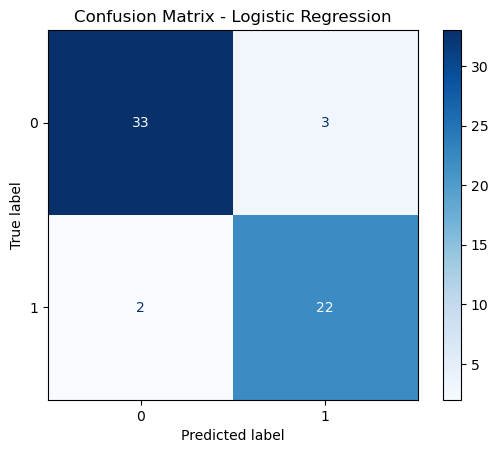


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        36
           1       0.88      0.92      0.90        24

    accuracy                           0.92        60
   macro avg       0.91      0.92      0.91        60
weighted avg       0.92      0.92      0.92        60



In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,  classification_report
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Linear Discriminat Analysis (LDA) and Quadratic Discriminant Analysis (QDA) can be used and compared to the Logistic Regression. LDA works well when the data for each class is normally distributed with equal covariance matrices. To check if this assumption is correct the Box's M Test can be used. If H0 is rejected the covariance matrixes aren't equal and using LDA isn't correct.

In [33]:
import pingouin as pg
pg.box_m(data=fin1, dvs=['age','thalach','oldpeak','ca','sex','cp','restecg',
       'exang','thal','slope_2','slope_3'],group="num")

,Chi2,df,pval,equal_cov
box,149.875491,45.0,3.370368e-13,False


p-value< 0.05-> hence we reject the null hypothesis.

Applying LDA shouldn't be the best choice in these case. QDA can be implemented as it does not require the assumption of equality of covariances.

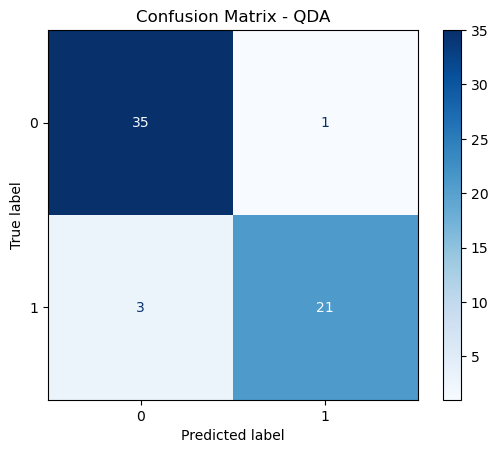


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.95      0.88      0.91        24

    accuracy                           0.93        60
   macro avg       0.94      0.92      0.93        60
weighted avg       0.93      0.93      0.93        60



In [34]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda=QuadraticDiscriminantAnalysis()
qda.fit(X_train,y_train)

y_pred_qda=qda.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_qda)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - QDA')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_qda))

Based on the classifications report QDA performs better than the simple Logistic Regression.

Classification Tree
A non-linear method, such as a decision tree, could be tested to determine if it outperforms the previous models.
In the classification tree it isn't necessary to encode variables, hence Train and Test division are created again, with the same random state. 

In [35]:
fin["num"]=fin["num"].astype("category")
fin.dtypes

age           int64
thalach       int64
oldpeak     float64
ca          float64
num        category
sex        category
cp         category
restecg    category
exang      category
slope      category
thal       category
dtype: object

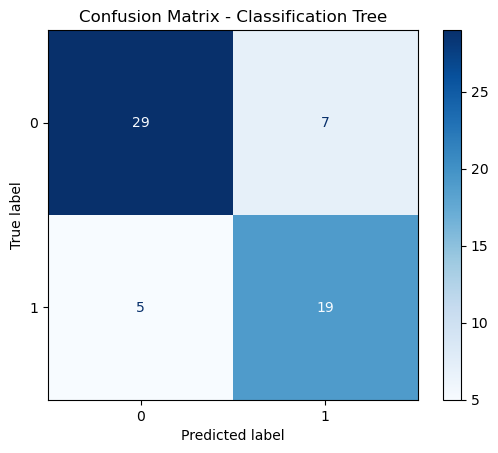


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        36
           1       0.73      0.79      0.76        24

    accuracy                           0.80        60
   macro avg       0.79      0.80      0.79        60
weighted avg       0.80      0.80      0.80        60



In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
X1=fin.drop("num",axis=1)
y1=fin["num"]

X_train1, X_test1, y_train1, y_test1= train_test_split(X1,y1,test_size=0.20, random_state=42)

clf = DecisionTreeClassifier()
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1_weighted', cv=5)
grid_search.fit(X_train1, y_train1)

best_clf = grid_search.best_estimator_

y_pred_clf = best_clf.predict(X_test1)

conf_matrix = confusion_matrix(y_test1, y_pred_clf)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Classification Tree')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test1, y_pred_clf))

At first glance, QDA appears to outperform all the other models. To confirm this, ROC curve and the respective AUC can be plotted for a more thorough comparison

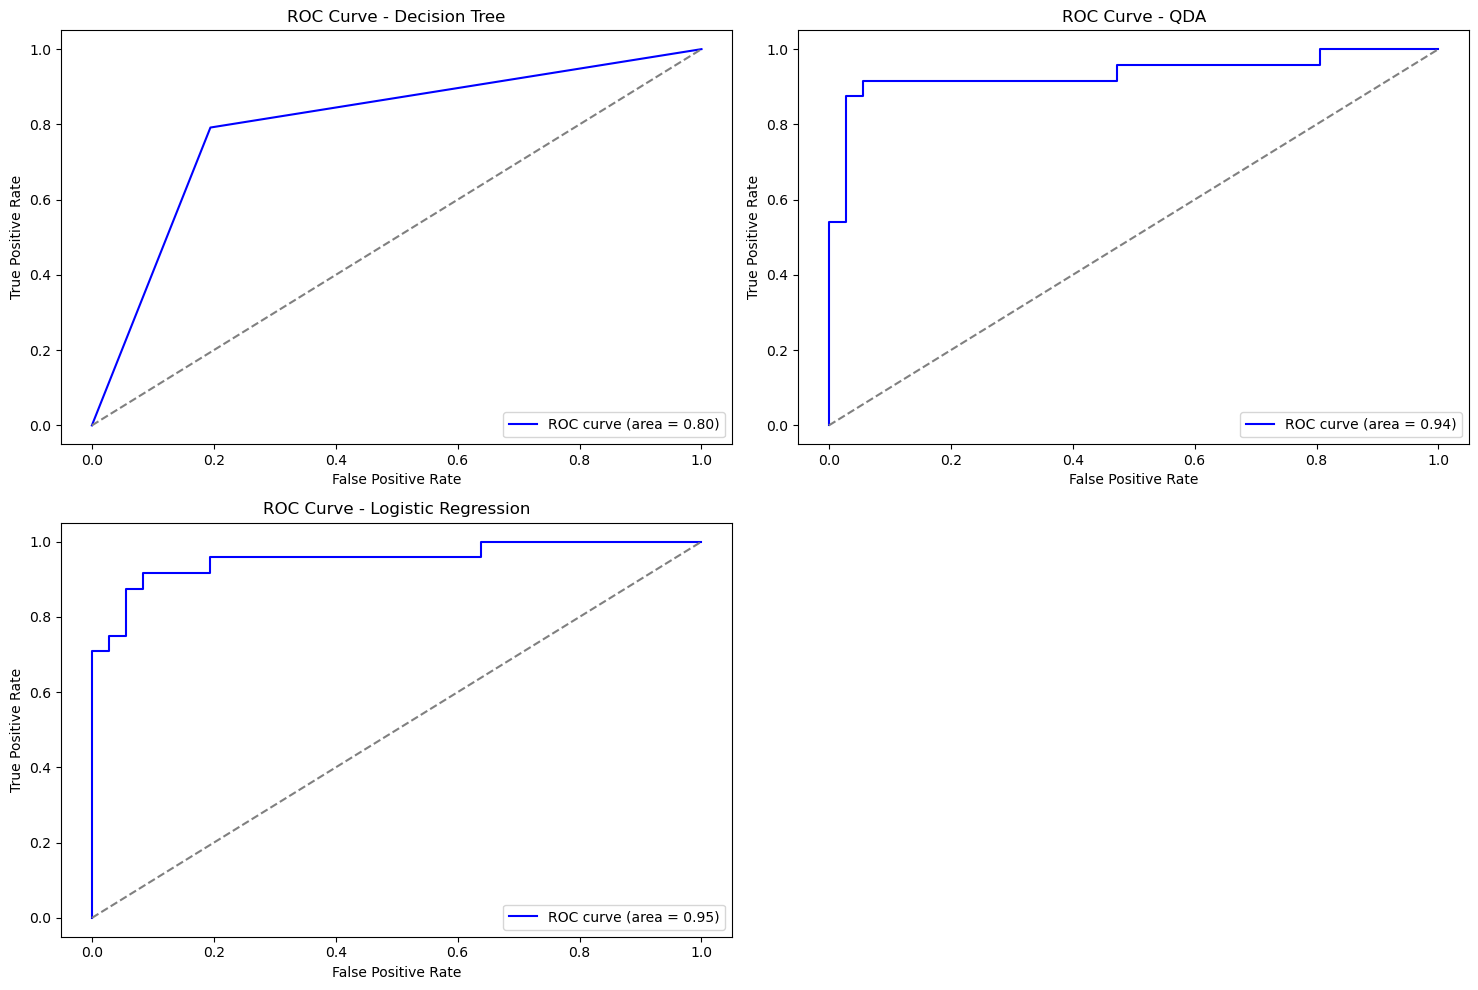

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, axes = plt.subplots(2,2, figsize=(15, 10))
axes = axes.flatten()  

y_prob_clf = best_clf.predict_proba(X_test1)[:, 1] 
y_prob_qda = qda.predict_proba(X_test)[:, 1] 
y_prob = log_reg.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_clf)
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_prob_qda)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_prob)

axes[0].plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_score(y_test1, y_prob_clf))
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Decision Tree')
axes[0].legend(loc='lower right')

axes[1].plot(fpr1, tpr1, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_prob_qda))
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - QDA')
axes[1].legend(loc='lower right')

axes[2].plot(fpr2, tpr2, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_prob))
axes[2].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve - Logistic Regression')
axes[2].legend(loc='lower right')

plt.subplots_adjust(hspace=0.4, wspace=0.4)  
plt.tight_layout()
axes[3].axis('off') 
plt.show()


The difference between Logistic Regression and Quadratic Discriminant Analysis (QDA) is minimal in both AUC and the Classification Report. At this point, neither model stands out as clearly preferable over the other, as they show comparable performance across the key evaluation metrics. Given this, both models seem to be viable options for the task at hand, and further exploration or consideration of other factors (like interpretability, etc.) might be required to make a final choice.